# Deep Learning: Final Project

## Setup

In [34]:
!pip install torch torchvision numpy matplotlib pandas

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\mrama\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [35]:
import torchvision
import numpy as np
import torch
from torch.utils.data import DataLoader
import json
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import pandas as pd

### Download pre-trained model

In [36]:
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

### Setup dataset

In [37]:
!unzip -n TestDataSet.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(mean=mean_norms, std=std_norms) 
])

batch_size = 128
dataset_path = "./TestDataSet"

orig_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
orig_dataloader = DataLoader(orig_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [39]:
# Load label mapping
with open(dataset_path + '/labels_list.json', "r") as f:
    label_list = json.load(f)
class_idx = [int(label.split(': ')[0]) for label in label_list]
class_label = [label.split(': ')[1] for label in label_list]

# map imagenet index to labels
imagenet_class_mapping = {idx: label for idx, label in zip(class_idx, class_label)}

# map dataset target to imagenet target
label_to_imagenet = {target: idx for target, idx in enumerate(class_idx)}

In [40]:
def denormalize(image, mean_norms=mean_norms, std_norms=std_norms):
    """denormalize image tensor using mean/std"""
    mean = torch.tensor(mean_norms).view(1, 3, 1, 1).to(image.device)
    std = torch.tensor(std_norms).view(1, 3, 1, 1).to(image.device)
    return torch.clamp(image * std + mean, 0, 1)

## Task 1: Evaluate pre-trained model

In [41]:
def evaluate(model, dataloader, save_preds=False, col_name=None, filepath='pred.csv'):
    model = model.to(device)
    model.eval()

    top1_correct = 0
    top5_correct = 0
    total = 0
    preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # map targets from test dataset to imagenet predictions
            imagenet_labels = torch.tensor(
                [label_to_imagenet[int(l)] for l in labels], device=device
            )

            # get preds
            outputs = model(images)
            _, top5_preds = outputs.topk(5, dim=1)

            # Top-1 accuracy
            top1_correct += (top5_preds[:, 0] == imagenet_labels).sum().item()
            preds.extend(top5_preds[:, 0].cpu().numpy())

            # Top-5 accuracy
            for i in range(images.size(0)):
                if imagenet_labels[i].item() in top5_preds[i]:
                    top5_correct += 1

            total += images.size(0)

    # Compute accuracy
    top1_acc = top1_correct / total
    top5_acc = top5_correct / total

    # save predictions in csv if needed
    if save_preds:
        if not col_name:
            raise ValueError('Expected column name')
        if os.path.isfile(filepath):
            df = pd.read_csv(filepath)
            df[col_name] = preds
        else:
            df = pd.DataFrame({col_name: preds})
        df.to_csv(filepath, index=False)

    print(f"Top-1 Accuracy: {top1_acc * 100:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc * 100:.2f}%")
    return preds

orig_preds = evaluate(pretrained_model, orig_dataloader, save_preds=True, col_name='orig')


Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


## Task 2: Pixel-wise attacks

https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [42]:
fgsm_output_dir = "./AdversarialTestSet1"
os.makedirs(fgsm_output_dir, exist_ok=True)

In [43]:
adv_dataloader = torch.utils.data.DataLoader(orig_dataset, batch_size=1, shuffle=False)
epsilon = 0.02 / std_norms
epsilon_tensor = torch.tensor(epsilon).view(1, 3, 1, 1).to(device, dtype=torch.float32)

In [44]:
# FGSM attack
def fgsm_attack(image, label, model, epsilon_tensor):
    image.requires_grad = True
    output = model(image)
    loss = F.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data

    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon_tensor * sign_data_grad
    min_vals = torch.tensor((0 - mean_norms) / std_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)
    max_vals = torch.tensor((1 - mean_norms) / std_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)

    return torch.clamp(perturbed_image, min=min_vals, max=max_vals).to(dtype=torch.float32)

In [45]:
# Save images
from pathlib import Path

# Get original image file paths from the dataset
original_paths = [Path(orig_dataset.imgs[i][0]) for i in range(len(orig_dataset))]

# Attack loop
orig_images = []
fgsm_images = []

for i, (image, label) in enumerate(adv_dataloader):
    image, label = image.to(device), label.to(device)
    # map targets from test dataset to imagenet predictions
    imagenet_label = torch.tensor([label_to_imagenet[int(label.item())]], device=device)
    fgsm_image = fgsm_attack(image.clone(), imagenet_label, pretrained_model, epsilon_tensor)
    orig_images.append(image.squeeze(0).cpu())
    fgsm_images.append(fgsm_image.squeeze(0).cpu())

    # Determine relative path inside dataset
    orig_path = original_paths[i]
    rel_path = orig_path.relative_to(orig_dataset.root)
    save_path = Path(fgsm_output_dir) / rel_path

    # Make directory if needed
    save_path.parent.mkdir(parents=True, exist_ok=True)

    # Convert and save
    img_denorm = denormalize(fgsm_image).squeeze(0)
    pil_img = TF.to_pil_image(img_denorm)
    pil_img.save(save_path)


### Get FGSM accuracy drop

In [46]:
fgsm_dataset = torchvision.datasets.ImageFolder(root=fgsm_output_dir, transform=plain_transforms)
fgsm_dataloader = DataLoader(fgsm_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
fgsm_preds = evaluate(pretrained_model, fgsm_dataloader, save_preds=True, col_name='fgsm')

Top-1 Accuracy: 6.00%
Top-5 Accuracy: 31.40%


### Verify L_inf

In [47]:
# Report L_inf statistics
def get_max_linf(orig_images, adv_images):
    # assert len(orig_dataset) == len(adv_dataset), "Datasets must have the same length"
    assert len(orig_dataset) == len(orig_images)

    max_diff = 0
    for orig_image, adv_image in zip(orig_images, adv_images):
        denorm_orig_image = denormalize(orig_image)
        denorm_adv_image = denormalize(adv_image)
        diff = torch.abs(denorm_orig_image - denorm_adv_image)
        max_diff = max(max_diff, diff.max().item())
    print(rf"Max L_inf difference: {max_diff:.5f}")

get_max_linf(orig_images, fgsm_images)

Max L_inf difference: 0.02000


### Get Successful Attack Samples

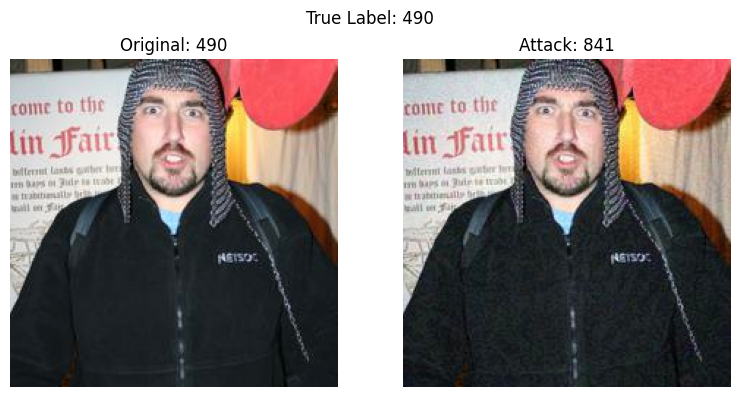

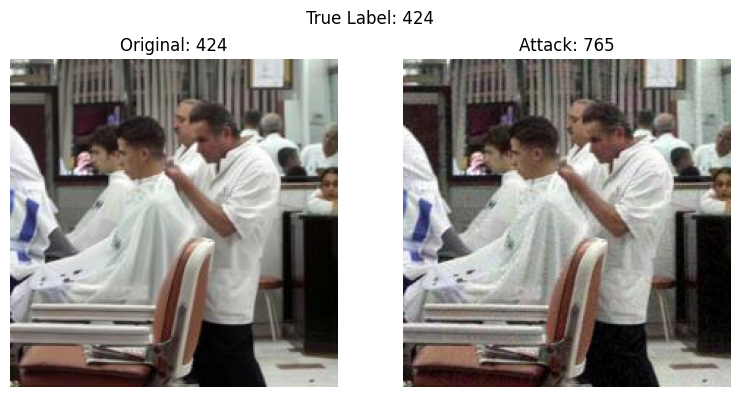

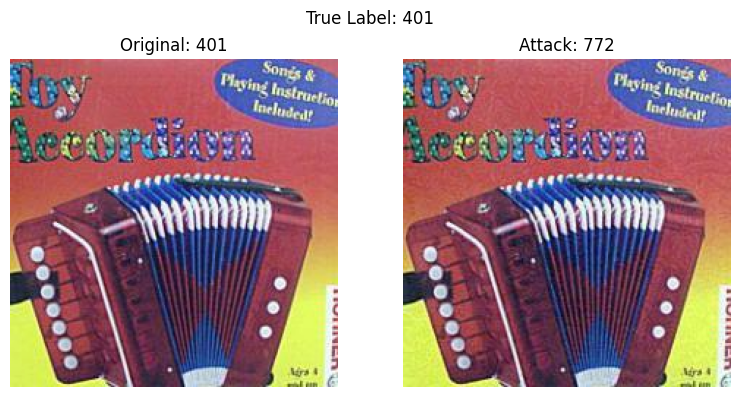

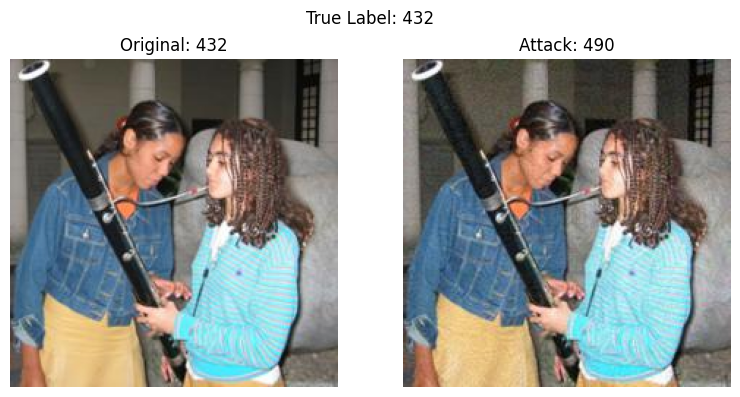

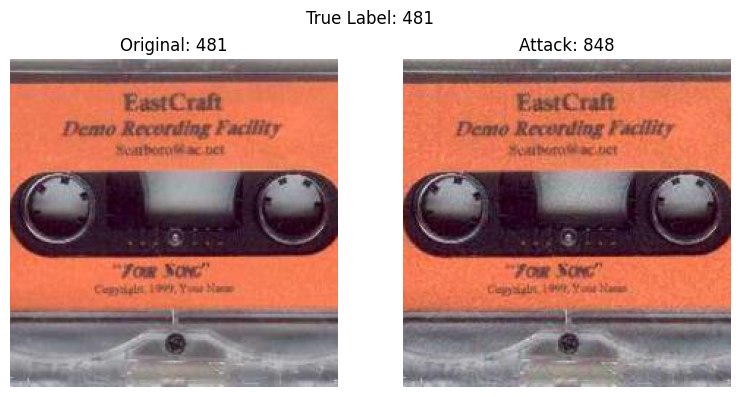

In [48]:
import random

def show_successful_attacks(indices, model, orig_dataset, adv_dataset):
    model.eval()

    for i in indices:
        # Load normalized images and label
        orig_img, label1 = orig_dataset[i]
        adv_img, _ = adv_dataset[i]
        label = label1

        # Run model
        with torch.no_grad():
            orig_pred = model(orig_img.unsqueeze(0).to(device)).argmax(dim=1).item()
            adv_pred = model(adv_img.unsqueeze(0).to(device)).argmax(dim=1).item()

        # Denormalize for visualization
        orig_vis = denormalize(orig_img.unsqueeze(0)).squeeze(0).cpu()
        adv_vis = denormalize(adv_img.unsqueeze(0)).squeeze(0).cpu()

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        fig.suptitle(f"True Label: {label_to_imagenet[label]}")
        axs[0].imshow(TF.to_pil_image(orig_vis))
        axs[0].set_title(f"Original: {orig_pred}")
        axs[1].imshow(TF.to_pil_image(adv_vis))
        axs[1].set_title(f"Attack: {adv_pred}")
        for ax in axs: ax.axis('off')
        plt.tight_layout()
        plt.show()

successful_attacks = []
df = pd.read_csv('pred.csv')

for idx, row in df.iterrows():
    img, label = orig_dataset[idx]
    if label_to_imagenet[label] == row['orig'] and row['orig'] != row['fgsm']:
        successful_attacks.append(idx)

# Show 5 random successful attacks
selected = random.sample(successful_attacks, min(5, len(successful_attacks)))
show_successful_attacks(selected, pretrained_model, orig_dataset, fgsm_dataset)


## Task 3: Improved Attacks

### Projected Gradient Descent

In [49]:
def pgd_attack(model, images, labels, epsilon, alpha, num_iter, mean_norms=mean_norms, std_norms=std_norms):
    """
    PGD attack under L∞ norm.

    Args:
        model: pretrained model
        images: normalized input images (B, C, H, W)
        labels: correct labels (mapped to ImageNet indices)
        epsilon: max perturbation (same shape as image or broadcastable)
        alpha: step size (same shape as epsilon)
        num_iter: number of attack steps
        mean_norms, std_norms: normalization used in preprocessing

    Returns:
        perturbed images (still normalized)
    """
    ori_images = images.clone().detach()
    perturbed = images.clone().detach().requires_grad_(True)

    for _ in range(num_iter):
        outputs = model(perturbed)
        model.zero_grad()
        loss = F.cross_entropy(outputs, labels)
        loss.backward()

        # Gradient sign
        grad_sign = perturbed.grad.data.sign()

        # Apply perturbation and clip to epsilon
        perturbed = perturbed + alpha * grad_sign
        delta = torch.clamp(perturbed - ori_images, min=-epsilon, max=epsilon)

        min_vals = torch.tensor((0 - mean_norms) / std_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)
        max_vals = torch.tensor((1 - mean_norms) / std_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)
        perturbed = torch.clamp(ori_images + delta, min=min_vals, max=max_vals).to(torch.float32)
        perturbed = perturbed.detach().requires_grad_(True)

    return perturbed


In [50]:
pgd_output_dir = "./AdversarialTestSet2"

alpha = epsilon / 4
alpha_tensor = torch.tensor(alpha).view(1, 3, 1, 1).to(device, dtype=torch.float32)

pgd_images = []

pretrained_model.eval()
for i, (image, label) in enumerate(adv_dataloader):
    image, label = image.to(device), label.to(device)
    imagenet_label = torch.tensor([label_to_imagenet[int(label.item())]], device=device)
    pgd_img = pgd_attack(pretrained_model, image, imagenet_label, epsilon_tensor, alpha_tensor, num_iter=10)
    pgd_images.append(pgd_img.cpu())

# Get original image file paths from the dataset
original_paths = [Path(orig_dataset.imgs[i][0]) for i in range(len(orig_dataset))]

# Save loop
for i, (img, orig_path) in enumerate(zip(pgd_images, original_paths)):
    # Determine relative path inside dataset
    rel_path = orig_path.relative_to(orig_dataset.root)
    save_path = Path(pgd_output_dir) / rel_path

    # Make directory if needed
    save_path.parent.mkdir(parents=True, exist_ok=True)

    # Convert and save
    img_denorm = denormalize(img).squeeze(0)
    pil_img = TF.to_pil_image(img_denorm)
    pil_img.save(save_path)


In [51]:
pgd_dataset = torchvision.datasets.ImageFolder(root=pgd_output_dir, transform=plain_transforms)
pgd_dataloader = DataLoader(pgd_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
pgd_preds = evaluate(pretrained_model, pgd_dataloader, save_preds=True, col_name='pgd')

Top-1 Accuracy: 1.00%
Top-5 Accuracy: 30.60%


In [52]:
get_max_linf(orig_images, pgd_images)

Max L_inf difference: 0.02000


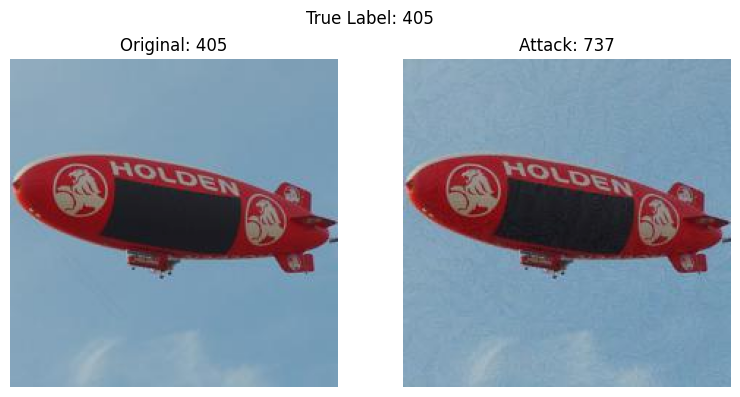

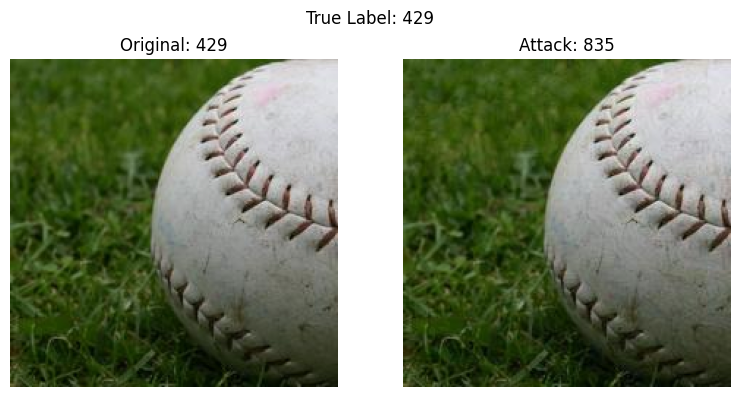

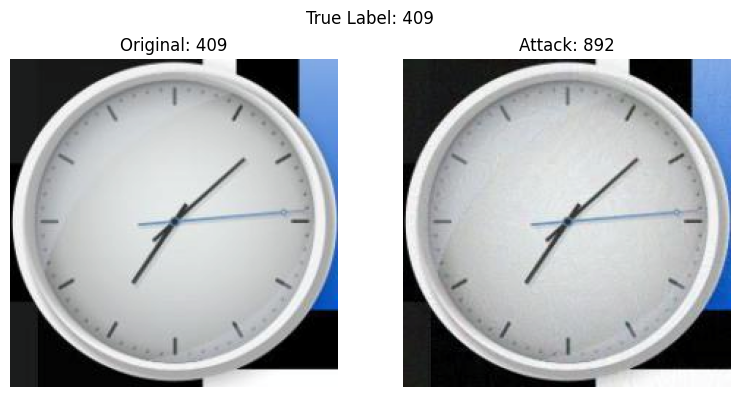

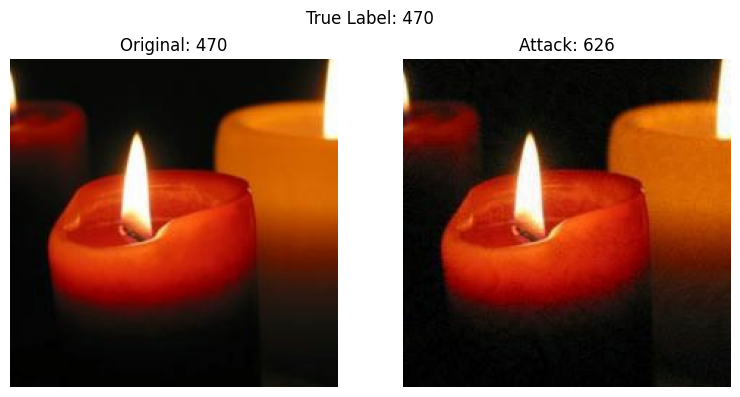

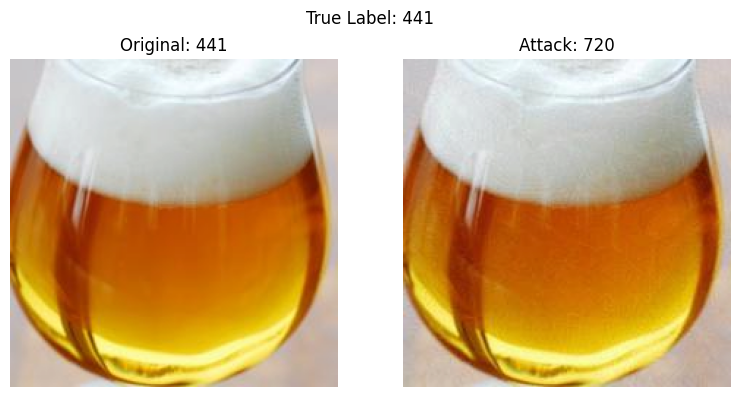

In [53]:
successful_attacks = []
df = pd.read_csv('pred.csv')

for idx, row in df.iterrows():
    img, label = orig_dataset[idx]
    if label_to_imagenet[label] == row['orig'] and \
       row['orig'] == row['fgsm'] and \
       row['fgsm'] != row['pgd']:
        successful_attacks.append(idx)

# Show 5 random successful attacks
selected = random.sample(successful_attacks, min(5, len(successful_attacks)))
show_successful_attacks(selected, pretrained_model, orig_dataset, pgd_dataset)

### Auto-PGD

In [54]:
def apgd_attack(model, image, label, epsilon_tensor, alpha_tensor, num_iter,
                mean_norms=mean_norms, std_norms=std_norms):
    """
    APGD attack

    Args:
        model: pretrained model
        images: normalized input images (B, C, H, W)
        labels: correct labels (ImageNet indices)
        epsilon: max perturbation (same shape as image or broadcastable)
        alpha: step size (same shape as epsilon)
        num_iter: number of steps
        mean_norms, std_norms: used for preprocessing
        loss_fn: 'ce' (cross-entropy) or 'dlr' (difference of logits ratio)

    Returns:
        perturbed images (still normalized)
    """
    ori_images = image.clone().detach()
    mean = torch.tensor(mean_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)
    std = torch.tensor(std_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)
    perturbed = ori_images + torch.empty_like(image).uniform_(-1.0, 1.0) * epsilon_tensor
    perturbed = perturbed.clamp((0 - mean) / std, (1 - mean) / std).detach().requires_grad_(True)

    best_adv = perturbed.clone().detach()
    best_loss = torch.full((image.size(0),), -float('inf'), device=device)

    for _ in range(num_iter):
        output = model(perturbed)
        loss = F.cross_entropy(output, label, reduction='none')
        grad = torch.autograd.grad(loss.sum(), perturbed)[0]
        perturbed = perturbed + alpha_tensor * grad.sign()
        delta = torch.clamp(perturbed - ori_images, -epsilon_tensor, epsilon_tensor)

        min_vals = torch.tensor((0 - mean_norms) / std_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)
        max_vals = torch.tensor((1 - mean_norms) / std_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)
        perturbed = torch.clamp(ori_images + delta, min_vals, max_vals).detach().requires_grad_(True)
        perturbed = perturbed.to(dtype=torch.float32)

        with torch.no_grad():
            outputs = model(perturbed)
            cur_loss = F.cross_entropy(outputs, label, reduction='none')
            mask = cur_loss > best_loss
            best_loss[mask] = cur_loss[mask]
            best_adv[mask] = perturbed[mask]

    return best_adv.detach()


In [55]:
apgd_output_dir = "./AdversarialTestSet3"

apgd_images = []

pretrained_model.eval()
for i, (image, label) in enumerate(adv_dataloader):
    image, label = image.to(device), label.to(device)
    imagenet_label = torch.tensor([label_to_imagenet[int(label.item())]], device=device)
    apgd_img = apgd_attack(pretrained_model, image, imagenet_label, epsilon_tensor, alpha_tensor, 10)
    apgd_images.append(apgd_img.cpu())

# Save loop
for i, (img, orig_path) in enumerate(zip(apgd_images, original_paths)):
    # Determine relative path inside dataset
    rel_path = orig_path.relative_to(orig_dataset.root)
    save_path = Path(apgd_output_dir) / rel_path

    # Make directory if needed
    save_path.parent.mkdir(parents=True, exist_ok=True)

    # Convert and save
    img_denorm = denormalize(img).squeeze(0)
    pil_img = TF.to_pil_image(img_denorm)
    pil_img.save(save_path)


In [56]:
apgd_dataset = torchvision.datasets.ImageFolder(root=apgd_output_dir, transform=plain_transforms)
apgd_dataloader = DataLoader(apgd_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
apgd_preds = evaluate(pretrained_model, apgd_dataloader, save_preds=True, col_name='apgd')

Top-1 Accuracy: 3.60%
Top-5 Accuracy: 44.40%


In [57]:
get_max_linf(orig_images, apgd_images)

Max L_inf difference: 0.02000


### Gaussian Noise Attack

In [ ]:
import torchattacks                   # https://adversarial-attacks-pytorch.readthedocs.io
gn_output_dir = "./AdversarialTestSet_GN"
os.makedirs(gn_output_dir, exist_ok=True)

#  Build the attacker.  'std' is BEFORE normalisation, so convert:
raw_std = 0.02                        # ≈1 raw‑pixel step (same budget as FGSM)
norm_std = raw_std / std_norms.mean() # quick heuristic: divide by mean σ
gn_attack = torchattacks.GN(pretrained_model, std=norm_std)

#  Generate & save perturbed images (mirrors ImageFolder layout)
gn_images, gn_targets = [], []        # keep in‑RAM copy for metrics
pretrained_model.eval()

for (img, target), orig_path in zip(adv_dataloader, original_paths):
    img, target = img.to(device), target.to(device)
    imagenet_target = torch.tensor([label_to_imagenet[int(target.item())]], device=device)

    with torch.no_grad():             # GN doesn’t use gradients
        adv_img = gn_attack(img, imagenet_target)

    # *** Clip to L∞ ≤ ε ***   (GN may exceed the budget on rare pixels)
    delta     = torch.clamp(adv_img - img, min=-epsilon_tensor, max=epsilon_tensor)
    adv_img   = img + delta

    # save PNG
    rel_path  = orig_path.relative_to(orig_dataset.root)
    save_path = Path(gn_output_dir)/rel_path
    save_path.parent.mkdir(parents=True, exist_ok=True)
    TF.to_pil_image(denormalize(adv_img).squeeze(0)).save(save_path)

    # bookkeeping
    gn_images .append(adv_img.squeeze(0).cpu())
    gn_targets.append(imagenet_target.cpu())

print("Gaussian Noise images written to", gn_output_dir)

#  Wrap in DataLoader and evaluate
gn_dataset   = torchvision.datasets.ImageFolder(root=gn_output_dir,
                                                transform=plain_transforms)
gn_loader    = DataLoader(gn_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=2)

print("\nResNet‑34 on Gaussian‑Noise set")
gn_preds = evaluate(pretrained_model, gn_loader, save_preds=True, col_name='gn')

#  Verify budget
get_max_linf(orig_images, gn_images)


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\mrama\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


Gaussian Noise images written to ./AdversarialTestSet_GN

ResNet‑34 on Gaussian‑Noise set
Top-1 Accuracy: 75.80%
Top-5 Accuracy: 94.20%
Max L_inf difference: 0.02000


### Jitter Attack

In [61]:
import torchattacks, types, math
from pathlib import Path


# 1) Wrap the ResNet so the attacker can work in RAW [0,1] space
class RawWrapper(torch.nn.Module):
    """Takes raw images in [0,1], normalises internally, then calls the model."""
    def __init__(self, model, mean, std):
        super().__init__()
        self.model = model
        self.register_buffer('mean', torch.tensor(mean).view(1,3,1,1))
        self.register_buffer('std' , torch.tensor(std ).view(1,3,1,1))
    def forward(self, x):
        x_norm = (x - self.mean) / self.std
        return self.model(x_norm)

wrapper = RawWrapper(pretrained_model, mean_norms.astype('float32'),
                     std_norms.astype('float32')).to(device).eval()

# 2) Instantiate Jitter with our ε / α in RAW space
raw_eps   = 0.02                    # identical budget to FGSM (~5.1/255)
raw_alpha = 0.005                   # a sane step (~1.3/255)
jit = torchattacks.Jitter(wrapper, eps=raw_eps, alpha=raw_alpha,
                          steps=10, scale=10, std=0.1, random_start=True)

# 3) Build adversarial set
jitter_dir = Path("./AdversarialTestSet_Jitter")
jitter_dir.mkdir(exist_ok=True)

jitter_imgs_norm, jitter_tgts = [], []   # store for L∞ check
mean = torch.tensor(mean_norms, dtype=torch.float32, device=device).view(1,3,1,1)
std  = torch.tensor(std_norms , dtype=torch.float32, device=device).view(1,3,1,1)

for (img_norm, target), orig_path in zip(adv_dataloader, original_paths):
    img_norm, target = img_norm.to(device), target.to(device)
    img_raw  = torch.clamp(img_norm * std + mean, 0, 1)

    tgt_imagenet = torch.tensor([label_to_imagenet[int(target.item())]], device=device)
    adv_raw = jit(img_raw, tgt_imagenet)           # returns RAW tensor ∈[0,1]

    # convert back to normalised space for evaluation / ∞‑budget check
    adv_norm = (adv_raw - mean) / std
    jitter_imgs_norm.append(adv_norm.squeeze(0).cpu())
    jitter_tgts     .append(tgt_imagenet.cpu())

    # save PNG (RAW) mirroring original folder tree
    rel_path = orig_path.relative_to(orig_dataset.root)
    save_path = jitter_dir / rel_path
    save_path.parent.mkdir(parents=True, exist_ok=True)
    TF.to_pil_image(adv_raw.squeeze(0).cpu()).save(save_path)

print("Jitter images written:", len(jitter_imgs_norm))

# 4) Evaluate ResNet‑34 on Jitter set
jitter_ds   = torchvision.datasets.ImageFolder(root=str(jitter_dir),
                                               transform=plain_transforms)
jitter_dl   = DataLoader(jitter_ds, batch_size=batch_size,
                         shuffle=False, num_workers=2)

print("\nResNet‑34 on Jitter set")
jitter_preds = evaluate(pretrained_model, jitter_dl, save_preds=True, col_name='jitter')

# 5) Verify ‖·‖∞ ≤ ε in RAW space
max_linf = 0.0
for o,a in zip(orig_images, jitter_imgs_norm):
    diff = torch.abs(denormalize(o.unsqueeze(0)) - denormalize(a.unsqueeze(0)))
    max_linf = max(max_linf, diff.max().item())
print(f"Max L_inf difference: {max_linf:.5f}")

Jitter images written: 500

ResNet‑34 on Jitter set
Top-1 Accuracy: 13.80%
Top-5 Accuracy: 80.20%
Max L_inf difference: 0.02000


## Task 4: Patch Attacks


In [67]:
def patch_pgd_attack(model, image, label, epsilon, alpha, num_iter,
                     mean_norms=mean_norms, std_norms=std_norms, patch_size=32):
    """
    PGD attack applied only to a patch of each image.

    Args:
        model: pretrained model
        images: normalized input images (B, C, H, W)
        labels: correct labels
        epsilon, alpha: scalar or broadcastable tensors
        num_iter: number of PGD steps
        mean_norms, std_norms: normalization used
        patch_size: square patch size to perturb

    Returns:
        Perturbed images (still normalized)
    """

    B, C, H, W = image.shape

    ori_image = image.clone().detach()
    perturbed = ori_image.clone().detach().requires_grad_(True)

    # Create patch mask
    patch_masks = torch.zeros_like(ori_image)
    top = (H - patch_size) // 2
    left = (W - patch_size) // 2
    patch_masks[:, :, top:top+patch_size, left:left+patch_size] = 1.0


    for _ in range(num_iter):
        output = model(perturbed)
        loss = F.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()

        grad_sign = perturbed.grad.data.sign()

        # Restrict update to patch only
        perturb_update = alpha * grad_sign * patch_masks
        perturbed = perturbed + perturb_update

        # Restrict delta and clip
        delta = torch.clamp(perturbed - ori_image, min=-epsilon, max=epsilon)
        delta = delta * patch_masks  # Only retain deltas in the patch

        min_vals = torch.tensor((0 - mean_norms) / std_norms, dtype=torch.float32, device=device).view(1, 3, 1, 1)
        max_vals = torch.tensor((1 - mean_norms) / std_norms, dtype=torch.float32, device=device).view(1, 3, 1, 1)
        perturbed = torch.clamp(ori_image + delta, min=min_vals, max=max_vals).detach().requires_grad_(True)

    return perturbed

In [ ]:
patch_pgd_output_dir = "./AdversarialTestSet4"

patch_pgd_images = []

patch_epsilon = 0.3 / std_norms
patch_epsilon_tensor = torch.tensor(patch_epsilon, dtype=torch.float32, device=device).view(1, 3, 1, 1)
patch_alpha = patch_epsilon / 10
patch_alpha_tensor = torch.tensor(patch_alpha).view(1, 3, 1, 1).to(device, dtype=torch.float32)

pretrained_model.eval()
for i, (image, label) in enumerate(adv_dataloader):
    image, label = image.to(device), label.to(device)
    imagenet_label = torch.tensor([label_to_imagenet[int(label.item())]], device=device)
    patch_pgd_img = patch_pgd_attack(pretrained_model, image, imagenet_label, patch_epsilon_tensor, patch_alpha_tensor, 200)
    patch_pgd_images.append(patch_pgd_img.cpu())

# Save loop
for i, (img, orig_path) in enumerate(zip(patch_pgd_images, original_paths)):
    # Determine relative path inside dataset
    rel_path = orig_path.relative_to(orig_dataset.root)
    save_path = Path(patch_pgd_output_dir) / rel_path

    # Make directory if needed
    save_path.parent.mkdir(parents=True, exist_ok=True)

    # Convert and save
    img_denorm = denormalize(img).squeeze(0)
    pil_img = TF.to_pil_image(img_denorm)
    pil_img.save(save_path)


In [78]:
patch_pgd_dataset = torchvision.datasets.ImageFolder(root=patch_pgd_output_dir, transform=plain_transforms)
patch_pgd_dataloader = DataLoader(patch_pgd_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
patch_pgd_preds = evaluate(pretrained_model, patch_pgd_dataloader, save_preds=True, col_name='patch_pgd')

Top-1 Accuracy: 7.60%
Top-5 Accuracy: 50.60%


## Task 5: Transferring Attacks

In [ ]:
new_model = torchvision.models.efficientnet_v2_s(weights='IMAGENET1K_V1')

dataloaders = {
    'original': orig_dataloader,
    'fgsm': fgsm_dataloader,
    'pgd': pgd_dataloader,
    'apgd': apgd_dataloader,
    'patch_pgd': patch_pgd_dataloader
}

for name, dataloader in dataloaders.items():
    print(f'Evaluating {name} dataset')
    evaluate(new_model, dataloader)
    print()


Evaluating original dataset
Top-1 Accuracy: 85.20%
Top-5 Accuracy: 98.40%

Evaluating fgsm dataset
Top-1 Accuracy: 69.60%
Top-5 Accuracy: 91.80%

Evaluating pgd dataset
Top-1 Accuracy: 77.40%
Top-5 Accuracy: 95.00%

Evaluating apgd dataset
Top-1 Accuracy: 78.80%
Top-5 Accuracy: 95.80%

Evaluating patch_pdd dataset
Top-1 Accuracy: 81.00%
Top-5 Accuracy: 97.60%

